In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans 

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth

import api_keys

## Importing data

In [2]:
# import and clean data
features_big = pd.read_csv('data/df_audio_features_5000.csv')
features_big.columns = features_big.columns.str.strip()
features_big.name = features_big.name.str.strip()
features_big = features_big.drop_duplicates(subset=['name', 'artist'])
features_big.set_index(["name","artist"], inplace=True)

In [3]:
features_big.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'duration_ms', 'time_signature', 'id', 'html'],
      dtype='object')

## Choosing features

In [6]:
# choose columns to include in the model (removed = key, mode, type, duration_ms, liveness, loudness)
features = ['danceability', 'energy', 'speechiness', 'acousticness', 
        'loudness', 'instrumentalness', 'valence', 'tempo']

features_only = features_big[features]

## Exploration of different scaling methods (big dataset)

### Range scaling

In [7]:
def range_scaler(col, min_value, max_value): 
    min_col = min_value
    max_col = max_value
    norm_val = []
    for val in col:
        norm_val.append((val - min_col) / (max_col - min_col))
    return norm_val

var_ranges = {'danceability': (0,1), 'energy': (0,1), 'key': (-1,11), 'loudness': (-60,0),
       'speechiness': (0,1), 'acousticness': (0,1), 'instrumentalness': (0,1), 'liveness': (0,1),
       'valence': (0,1)}

def range_scale_df(df):
    
    cols = df.columns
    scaled_cols = {}

    for col in cols:
        if col in var_ranges.keys():
            scaled_cols[col] = range_scaler(df[col], var_ranges[col][0], var_ranges[col][1])
        else:
            min_max_scaler = MinMaxScaler(feature_range= (0, 1))
            min_max_scaler.fit(df[[col]])
            scaled_cols[col] = list(min_max_scaler.transform(df[[col]]))
    
    features_only_range_scaled = pd.DataFrame(scaled_cols)
    return features_only_range_scaled

In [8]:
# apply scaling to data
range_scaled = range_scale_df(features_only)
range_scaled['tempo'] = range_scaled['tempo'].astype('float64')

### Min max scaling

In [9]:
# initialize transformer to scale data to [0, 1]
min_max_scaler = MinMaxScaler(feature_range= (0, 1))
min_max_scaler.fit(features_only)
features_only_min_max_scaled = min_max_scaler.transform(features_only)

min_max_scaled = pd.DataFrame(features_only_min_max_scaled,
                                index= features_only.index,
                                columns= features_only.columns)

### Standard scaling

In [10]:
# initialize transformer to remove the mean and scale by variance 
standard_scaler = StandardScaler()
standard_scaler.fit(features_only)
features_only_standard_scaled = standard_scaler.transform(features_only)

standard_scaled = pd.DataFrame(features_only_standard_scaled,
                                index= features_only.index,
                                columns= features_only.columns)

### Robust scaling

In [11]:
# initialize transformer to remove the median and scale by quantile range (more robust to outliers than standard scaler)
robust_scaler = RobustScaler()
robust_scaler.fit(features_only)
features_only_robust_scaled = robust_scaler.transform(features_only)

robust_scaled = pd.DataFrame(features_only_robust_scaled,
                                index= features_only.index,
                                columns= features_only.columns)

### Quantile Transforming

In [12]:
# initialize transformer to transform data to uniform distribution
quantile_transformer = QuantileTransformer(output_distribution='normal')
quantile_transformer.fit(features_only)
features_only_quantile_transformed = quantile_transformer.transform(features_only)

quantile_transformed = pd.DataFrame(features_only_quantile_transformed,
                                index= features_only.index,
                                columns= features_only.columns)

### Visualize different scaling/transformation methods

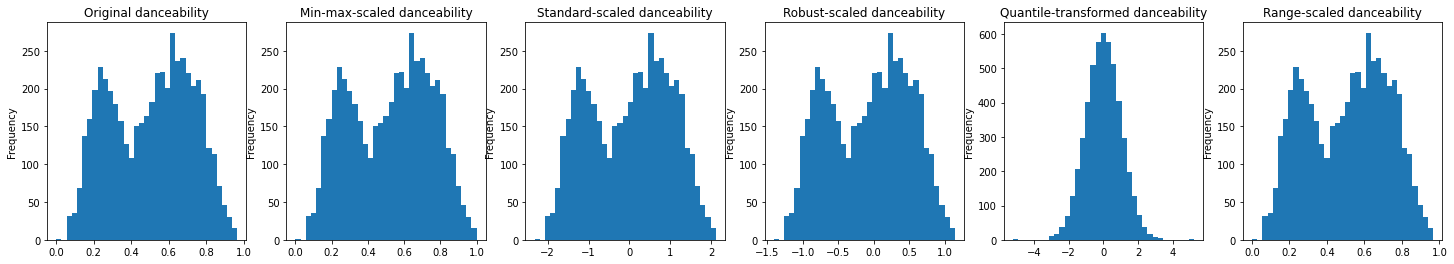

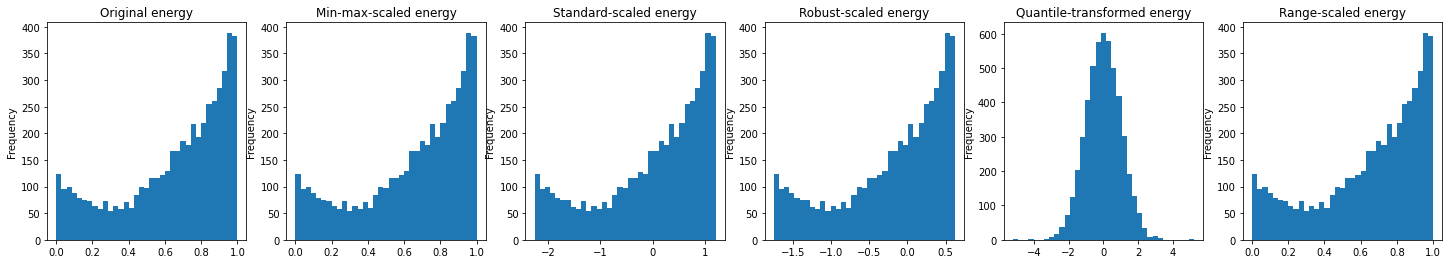

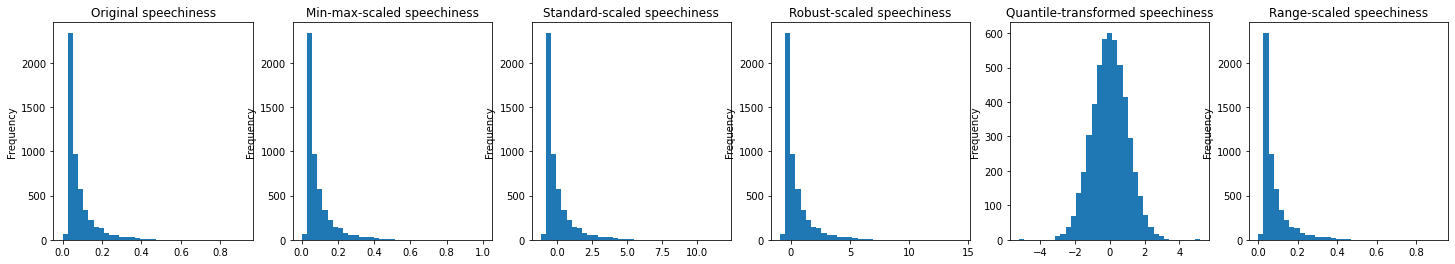

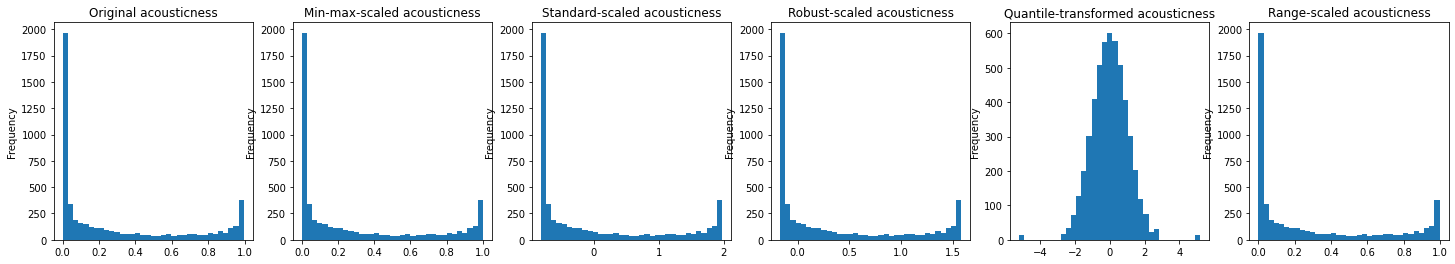

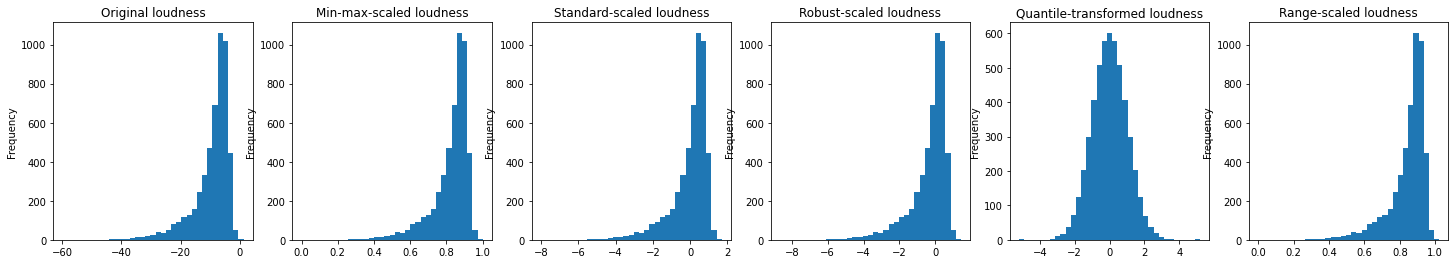

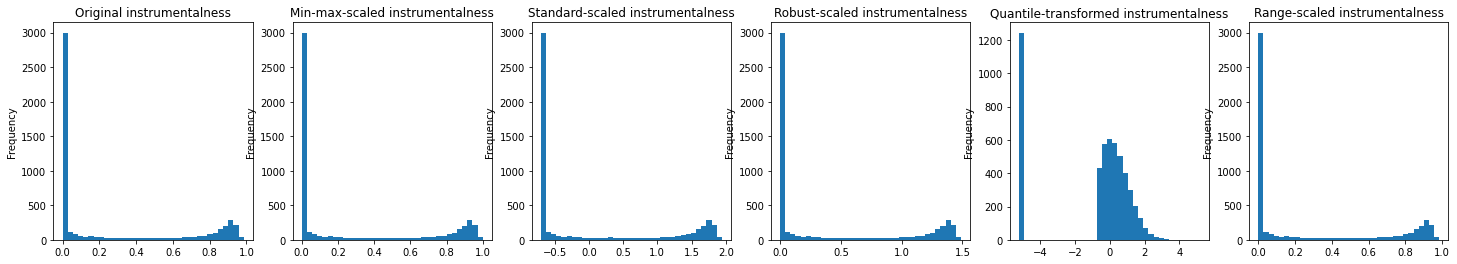

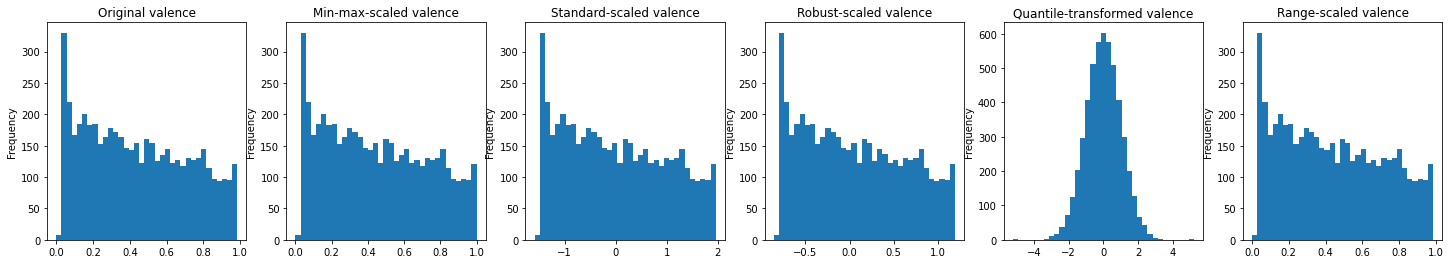

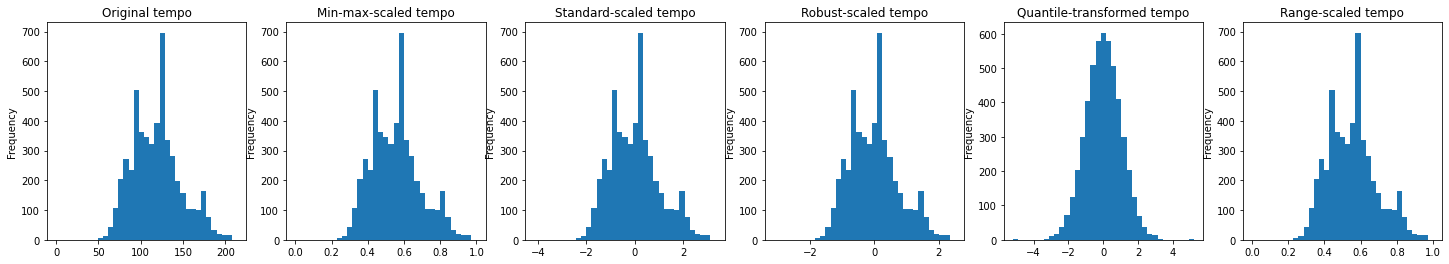

In [13]:
# loop through each relevant column to compare distributions

for var in features:
    plt.figure(figsize=(25, 4))
    
    # plot original data
    plt.subplot(1, 6, 1)
    features_big[var].plot.hist(bins=35)
    plt.title(f"Original {var}")
    
    # plot min-max scaled data
    plt.subplot(1, 6, 2)
    min_max_scaled[var].plot.hist(bins=35)
    plt.title(f"Min-max-scaled {var}")

    # plot standard scaled data
    plt.subplot(1, 6, 3)
    standard_scaled[var].plot.hist(bins=35)
    plt.title(f"Standard-scaled {var}")

    # plot robust scaled data
    plt.subplot(1, 6, 4)
    robust_scaled[var].plot.hist(bins=35)
    plt.title(f"Robust-scaled {var}")

    # plot quantile transformed data
    plt.subplot(1, 6, 5)
    quantile_transformed[var].plot.hist(bins=35)
    plt.title(f"Quantile-transformed {var}")

     # plot range-scaled data
    plt.subplot(1, 6, 6)
    range_scaled[var].plot.hist(bins=35)
    plt.title(f"Range-scaled {var}")
    
    # show all plots
    plt.show()

### Decision on scaling method

For one attempt range-scaling is used for variables that already have a range of [0,1] and min-max-scaling is used for variables that don't have a set range.
For another attempt a quantile transformation to a Gaussian distribution is employed.

## Set random state
This allows this notebook to be reproducible.

In [14]:
random_state = 42

## Find best k

In [15]:
def find_best_k(data, min_n_clusters, max_n_clusters, random_state):
    inertia_values = []
    silhouette_scores = []
    n_clusters = range(min_n_clusters, max_n_clusters + 1)

    for n in n_clusters:
        kmeans = KMeans(n_clusters= n, random_state=random_state)
        kmeans.fit(data)
        inertia_values.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))

    plt.subplots(figsize = (25,10))

    plt.subplot(1,2,1)
    plt.plot(n_clusters, inertia_values, 'bx-')
    plt.xticks(n_clusters)
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Elbow Method For Optimal k')

    plt.subplot(1,2,2)
    plt.plot(n_clusters, silhouette_scores, 'bx-')
    plt.xticks(n_clusters)
    plt.xlabel('k')
    plt.ylabel('silhouette score')
    plt.title('Silhouette Scores For Optimal k')

    plt.show()

Range scaled:


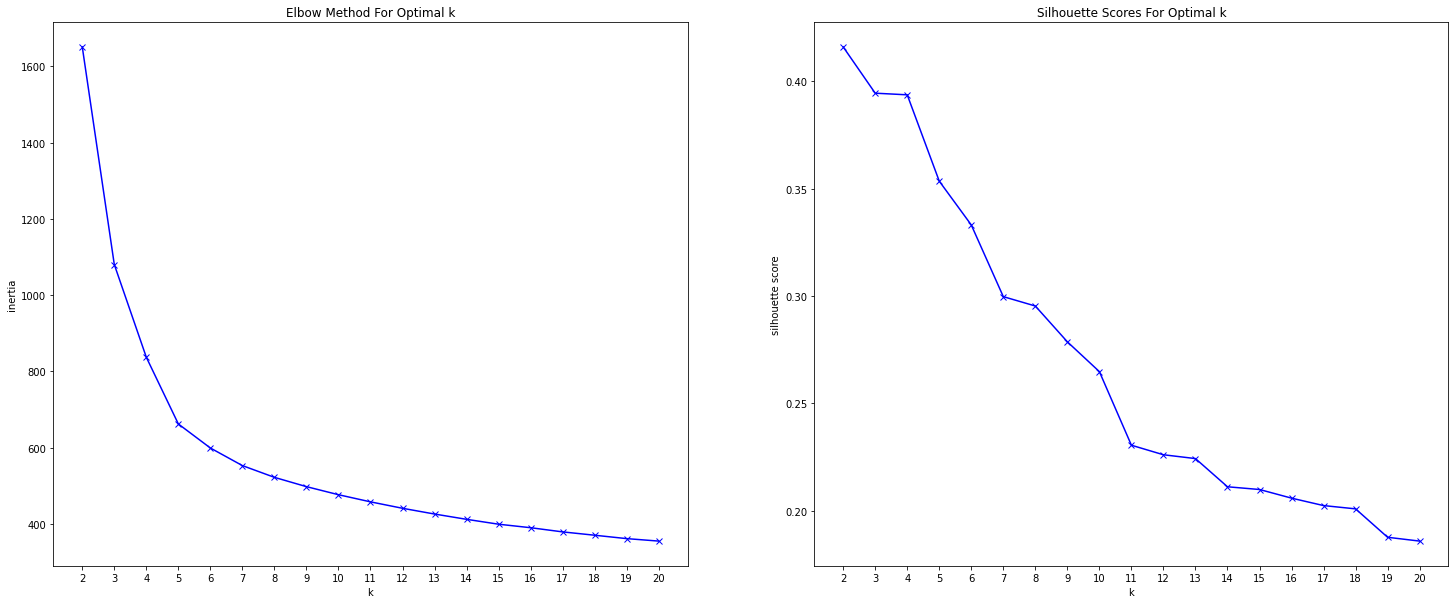

Quantile transformed:


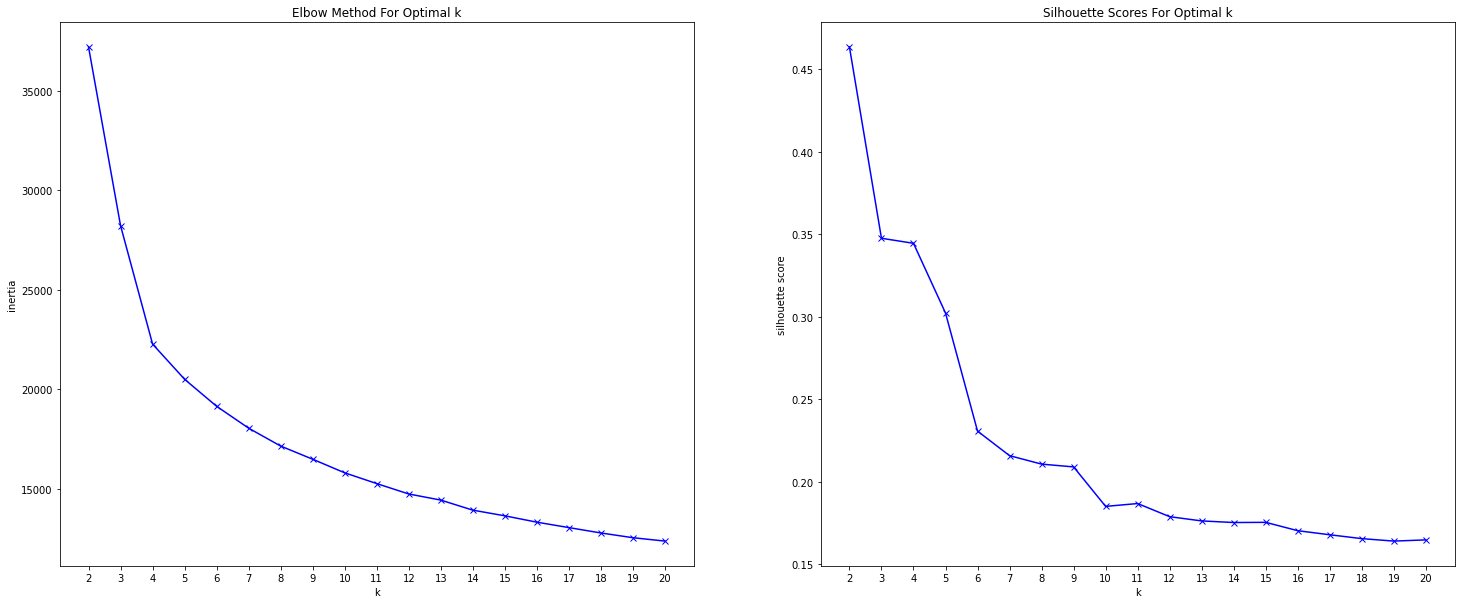

In [16]:
print('Range scaled:')
find_best_k(range_scaled, 2, 20, random_state)

print('Quantile transformed:')
find_best_k(quantile_transformed, 2, 20, random_state)

# commented out to decrease runtime

# print('Min-max scaled:')
# find_best_k(min_max_scaled, 2, 20)

# print('Standard scaled:')
# find_best_k(standard_scaled, 2, 20)

# print('Robust scaled:')
# find_best_k(robust_scaled, 2, 20)

### Programmatic way to find best k

In [15]:
# elbow locator function, output is (best k, (min k, max k))

from kneed import KneeLocator

def best_k_value(data, min_clusters, max_clusters):
    inertia_values = []
    silhouette_scores = []
    number_clusters = range(min_clusters, max_clusters + 1)

    for n in number_clusters:
        k_means = KMeans(n_clusters= n)
        k_means.fit(data)
        inertia_values.append(k_means.inertia_)
        silhouette_scores.append(silhouette_score(data, k_means.labels_))
        
    
    sensitivity = [1, 3, 5, 10, 20, 30, 50]
      
    in_el_list =[]
    si_el_list = []
    for i in range(10):
        silhouette_elbows =[]
        inertia_elbows = []
        for s in sensitivity:
            kl_s = KneeLocator(number_clusters, silhouette_scores, curve="convex", direction="decreasing", S=s)
            silhouette_elbows.append(kl_s.elbow)
            kl_i = KneeLocator(number_clusters, inertia_values, curve="convex", direction="decreasing", S=s)
            inertia_elbows.append(kl_i.elbow) 
        in_el_list.append(np.max([in_elbow  for in_elbow in inertia_elbows if in_elbow !=None]))
        si_el_list.append(np.max([si_elbow  for si_elbow in silhouette_elbows if si_elbow !=None]))
    in_el_mean = np.mean(in_el_list)
    si_el_mean = np.mean(si_el_list)
    if in_el_mean >= si_el_mean:
      return best_k_value(data, min_clusters, max_clusters)
    return np.mean([in_el_mean,si_el_mean]), (in_el_mean,si_el_mean)


# best_k_value(quantile_transformed, 2, 20)

## Conduct clustering

In [17]:
# choose which scaled data to use
data = range_scaled.copy()

### Clustering functions

In [19]:
def get_clusters(data, k, random_state):
    # initialize the clusters
    kmeans = KMeans(n_clusters= k, random_state= random_state)

    # fit the clusters to the data
    kmeans.fit(data) 

    # obtain the cluster output
    clusters = kmeans.predict(data)

    return kmeans, clusters

def get_centroids(kmeans, data):
    centroids = kmeans.cluster_centers_
    centroids_df = pd.DataFrame(centroids)
    centroids_df.columns = data.columns
    
    return centroids_df

### Single-level clustering
After finishing this section, move on to "Creating Playlists" section.   
SKIP MULTILEVEL CLUSTERING SECTION!

In [21]:
kmeans, clusters = get_clusters(data= data, k= 10, random_state= random_state)

# add the cluster output to the dataframes
data['cluster'] = clusters

final_cluster_df = data.copy()
centroid_df = get_centroids(kmeans, data.iloc[:,:-1])
centroid_df['cluster'] = centroid_df.index

### Multilevel clustering

#### Get first level of clusters

In [18]:
kmeans, clusters = get_clusters(data= data, k= 3, random_state= random_state)

# add the cluster output to the dataframes
data['cluster'] = clusters

#### Transform data in new clusters

##### Quantile Transformation

In [19]:
# initialize transformer to transform data to uniform distribution
transformed_clusters = []

for cluster in data['cluster'].unique():
    cluster_data = data.loc[data['cluster'] == cluster]
    quantile_transformer.fit(cluster_data.drop(columns= 'cluster'))
    features_only_transformed_cluster = quantile_transformer.transform(cluster_data.drop(columns= 'cluster'))

    transformed_cluster = pd.DataFrame(features_only_transformed_cluster,
                                        columns= features)
    transformed_cluster.set_index(cluster_data.index, inplace= True)
    transformed_cluster['cluster'] = cluster_data['cluster']
    
    
    transformed_clusters.append(transformed_cluster)

data_second_lvl = pd.concat(transformed_clusters)

#### Get second level of clusters

Cluster number: 0


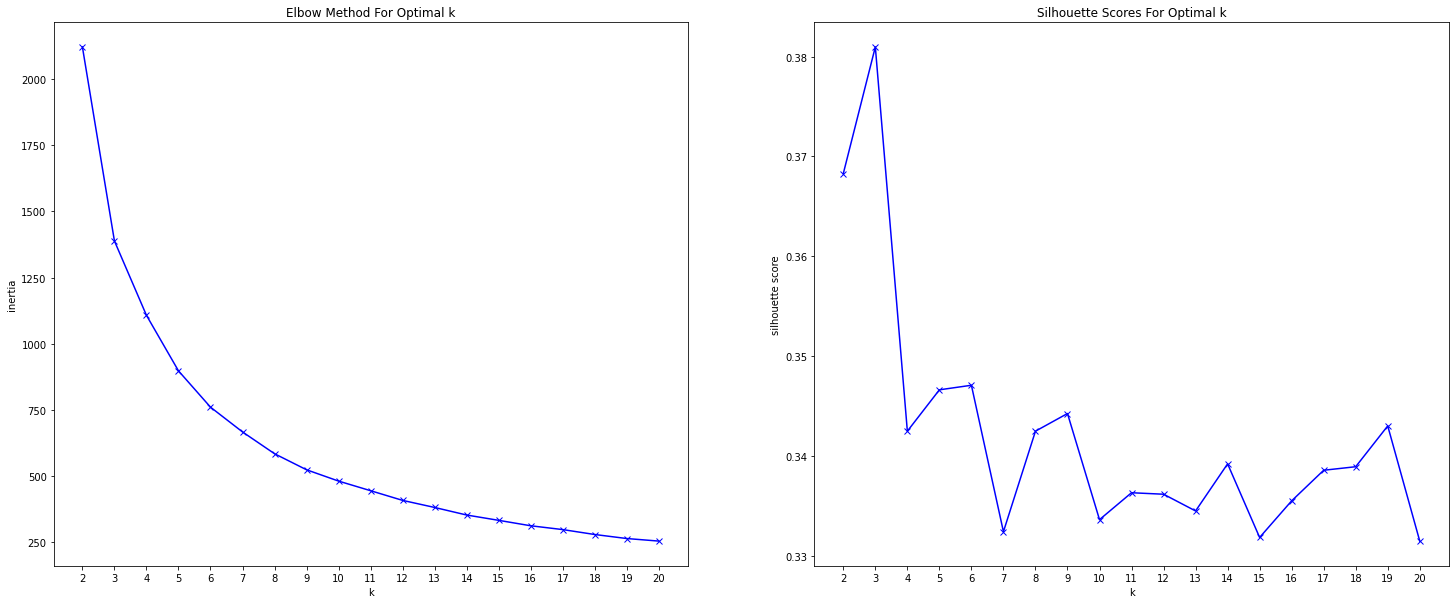

Cluster number: 1


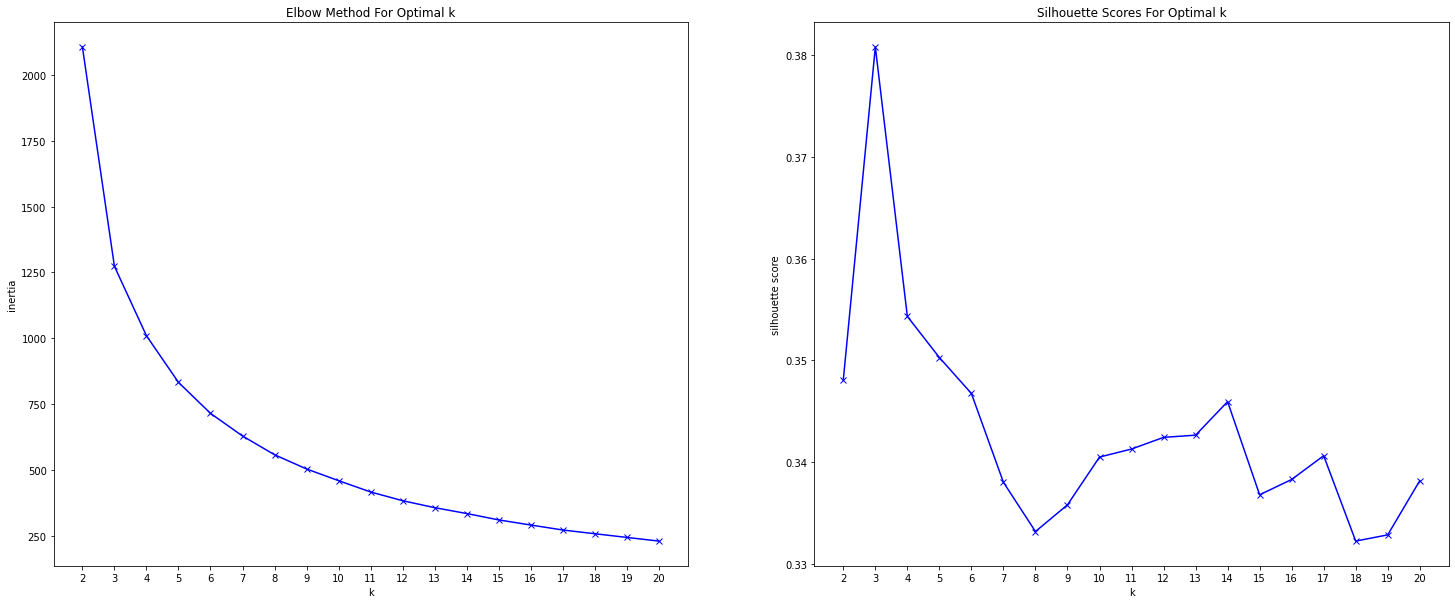

Cluster number: 2


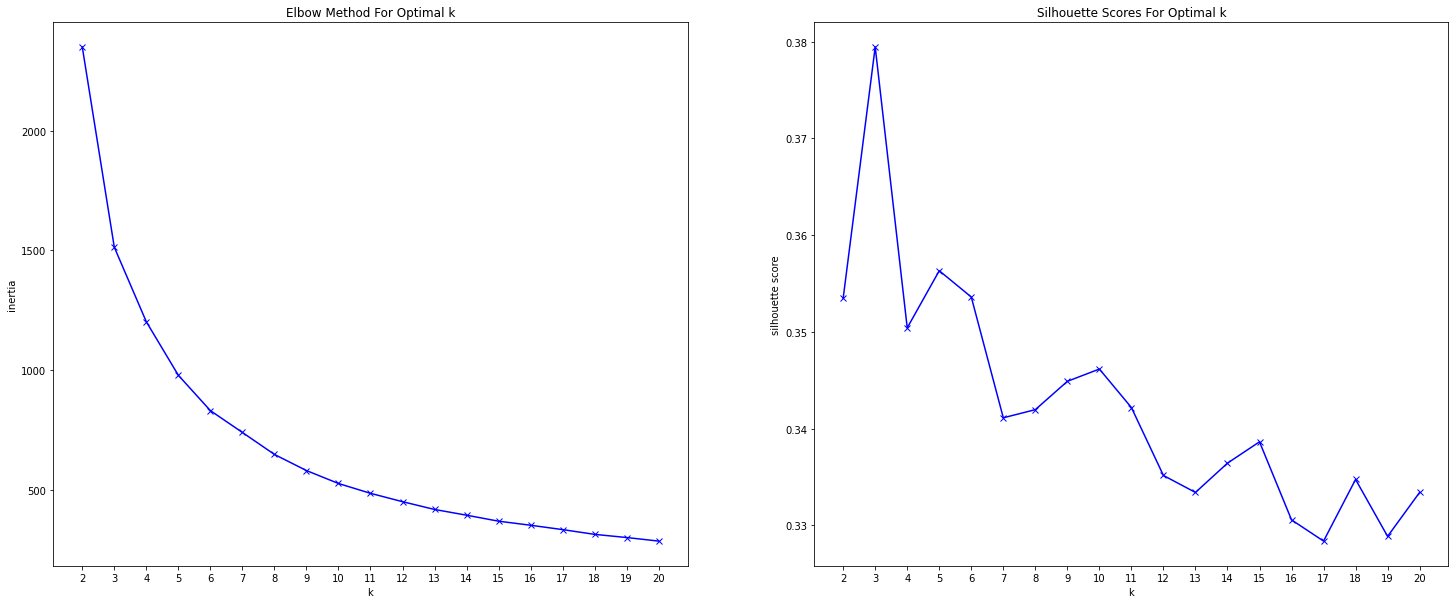

In [20]:
# find best k for first clusters:
for cluster in range(len(data_second_lvl['cluster'].unique())):
    current_cluster = data_second_lvl[data_second_lvl['cluster'] == cluster]
    print(f'Cluster number: {cluster}')
    find_best_k(current_cluster, 2, 20, random_state)

In [21]:
# make choice of k for subclusters based on plots
desired_k_list = [3, 3, 3]
final_cluster_dfs = []
centroid_dfs = []
current_total_nr_clusters = 0

for cluster in range(len(data_second_lvl['cluster'].unique())):
    current_cluster = data_second_lvl[data_second_lvl['cluster'] == cluster].copy()
    kmeans, clusters = get_clusters(current_cluster, desired_k_list[cluster], random_state)
    current_cluster['cluster'] = clusters + current_total_nr_clusters

    centroid_df = get_centroids(kmeans, current_cluster)
    centroid_df['cluster'] = centroid_df.index + current_total_nr_clusters
    
    current_total_nr_clusters += desired_k_list[cluster]

    centroid_dfs.append(centroid_df)
    final_cluster_dfs.append(current_cluster)

# concatenate all dataframes to one big dataframe
final_cluster_df = pd.concat(final_cluster_dfs)

# concatenate centroids for each cluster
centroid_df = pd.concat(centroid_dfs)

## Creating playlists

### Find the most fitting songs by taking the 30 songs that are closest to their respective centroid per cluster 

In [30]:
# function returns a list of all euclidian distances between each point and its centroid

def calculate_euclidian_distance(data, centroid_df):
    # create reindex scaled clustered df for calculating the distance
    # this avoids problems with using the name as the index as there are duplicate names
    # data_reindexed = data.reset_index().copy()
    
    euclidian_distances = []

    for row in data.iterrows():
        
        distances = []
        for col in features:
            centroid = row[1]['cluster']
            row_distance = ((data[col][row[0]] - centroid_df.loc[centroid_df['cluster'] == centroid, col]) ** 2)
            distances.append(row_distance)

        euclidian_distances.append(sum(distances) ** 0.5)

    return euclidian_distances

In [31]:
# get distances and create a new df with results
final_cluster_df['euclidian_distance_to_centroid'] = calculate_euclidian_distance(final_cluster_df, centroid_df)
title_distance = final_cluster_df[['euclidian_distance_to_centroid', 'cluster']].copy()
title_distance['euclidian_distance_to_centroid'] = title_distance['euclidian_distance_to_centroid'].astype(float)

In [32]:
# extract the 30 songs with the lowest distance to their centroid from each cluster

cluster_song_lists = []

for cluster in title_distance.cluster.unique():
    top30_song_list = title_distance.query("cluster == @cluster").sort_values('euclidian_distance_to_centroid').head(30)
    cluster_song_lists.append(top30_song_list.index.tolist())

top30_df = pd.DataFrame()
for nr, song_list in enumerate(cluster_song_lists):
    top30_df[nr] = song_list

### Explore clusters to find labels

In [33]:
# extra_data = ['name', 'artist', 'cluster']
# extra_data.extend(features)
(
    final_cluster_df
        .groupby(by= 'cluster')
        .mean()
)

,danceability,energy,speechiness,acousticness,loudness,instrumentalness,valence,tempo
cluster,,,,,,,,
0,0.597275,0.774605,0.065656,0.123758,0.877725,0.716928,0.591964,0.613699
1,0.607720,0.726889,0.075902,0.091922,0.900998,0.015226,0.362302,0.572425
2,0.319968,0.131431,0.045028,0.934599,0.632497,0.869349,0.162532,0.490697
3,0.259275,0.905288,0.103893,0.007119,0.860471,0.805380,0.214610,0.566274
4,0.365122,0.161651,0.043465,0.905683,0.716318,0.054728,0.212524,0.498003
5,0.656010,0.837018,0.088367,0.073601,0.910571,0.015490,0.747373,0.609098
6,0.302047,0.924421,0.122029,0.011060,0.889535,0.102160,0.208848,0.570639
7,0.567634,0.392856,0.054246,0.677301,0.817990,0.039364,0.470919,0.538461
8,0.760051,0.620637,0.101864,0.173672,0.871291,0.009921,0.737757,0.493971


In [34]:
final_cluster_df.groupby(by = 'cluster').agg(count = ('cluster', 'count'))

,count
cluster,
0,167
1,788
2,578
3,740
4,224
5,723
6,523
7,418
8,606


### Cluster Labels
- 0 = ?
- 1 = ?
- 2 = ?
- 3 = ?
- 4 = ?
- 5 = ?
- 6 = ?

## Connect to Spotify API

In [35]:
# authentification for spotify api
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
                        scope= "playlist-modify-public",
                        client_id= api_keys.client_id,
                        client_secret= api_keys.client_secret,
                        redirect_uri= "http://localhost:8888/callback",
                        cache_path="token.txt"))

In [36]:
# get a list of titles for the top 30 songs in each cluster
title_lists = []
for cluster in top30_df.columns:
    title_lists.append(top30_df[cluster].tolist())

# get the song ids from the spotify api
id_lists = []
for title_list in title_lists:
    id_list = []
    for title in title_list:
        try:
            search = sp.search(q=title, limit = 1)
        except:
            print(f'Song not found and therefore skipped. Title: {title}')
            continue
        try:
            id_list.append(search["tracks"]["items"][0]["uri"])
        except:
            print(f'Error with song. Title: {title}')
            continue
    id_lists.append(id_list)

In [38]:
# automatically create a playlist for each cluster on the currently authenticated account
import time

for cluster_number, id_list in enumerate(id_lists):

    playlist_id = sp.user_playlist_create(api_keys.spotify_user_id, 
                                            f'1_layer_k10_{cluster_number}', 
                                            public=True, 
                                            collaborative=False, 
                                            description=f'Playlist with songs from Cluster {cluster_number}')['id']

    sp.user_playlist_add_tracks(api_keys.spotify_user_id, playlist_id, id_list)
    time.sleep(10)